In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun

%matplotlib inline

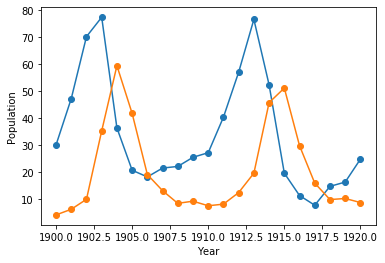

In [2]:
## Predator Prey Model

df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T

plt.figure()
plt.plot(year,hare,'-o')
plt.plot(year,lynx,'-o')
plt.xlabel('Year')
plt.ylabel('Population')
plt.show()

In [3]:
def predator_prey_sunode(t, y, p):
    du_dt = (p.alpha - p.beta * y.v) * y.u
    dv_dt = (-p.gamma + p.delta * y.u) * y.v
    return {'u': du_dt, 'v' : dv_dt}

In [8]:
model_sunode = pm.Model()

with model_sunode:
    
    sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2)
    alpha = pm.Normal('alpha', mu=1, sigma=0.5)
    gamma = pm.Normal('gamma', mu=1, sigma=0.5)
    beta  = pm.Normal('beta', mu=0.05, sigma=0.05)
    delta = pm.Normal('delta', mu=0.05, sigma=0.05)
    y0    = pm.Lognormal('y0', mu=pm.math.log(10), sigma=1, shape=2)
    
    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'alpha': (alpha, ()),
                'beta':  (beta, ()),
                'gamma': (gamma, ()),
                'delta': (delta, ()),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode,
            tvals=times,
            t0=times[0],
        )[0]
    
    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs[:,1])

In [9]:
with model_sunode:
    trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.9, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y0, delta, beta, gamma, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [07:37<00:00, 13.13draws/s]


/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/dis

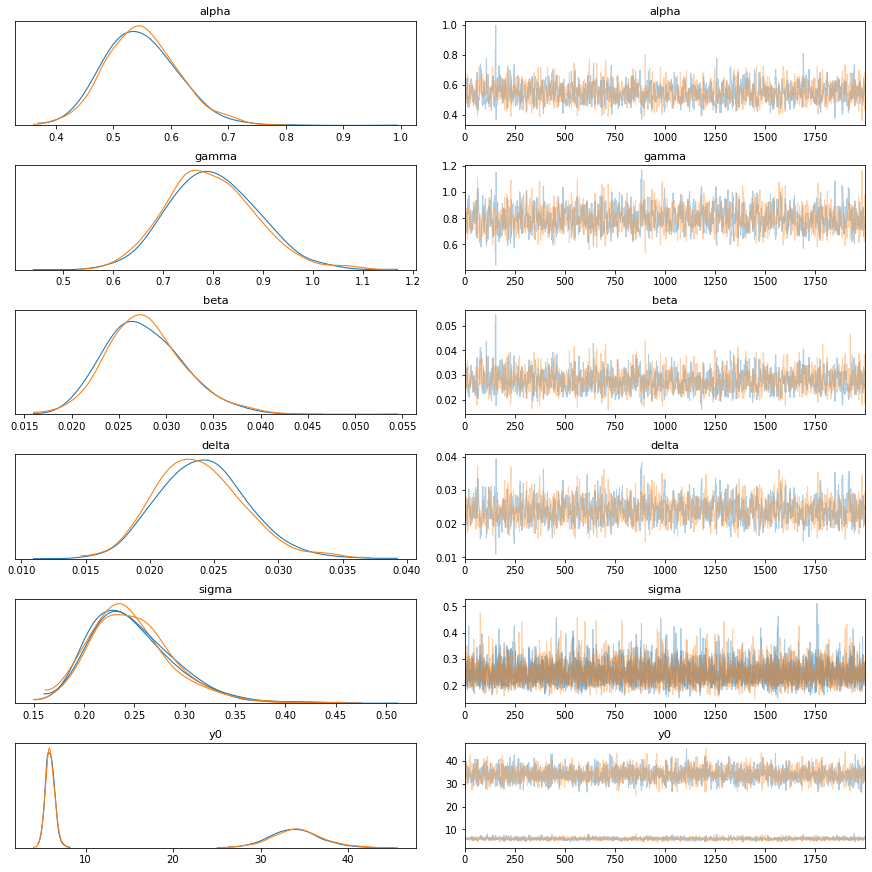

In [10]:
pm.traceplot(trace);

In [11]:
def predator_prey_sunode_library(t, y, p):
    du_dt = p.p0 * y.u + p.pn0 * y.u * y.u + p.pn2 * y.u * y.v
    dv_dt = p.p1 * y.v + p.pn1 * y.v * y.v + p.pn3 * y.u * y.v
    return {'u': du_dt, 'v' : dv_dt}

In [12]:
model_sunode = pm.Model()

with model_sunode:
    
    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    p0 = pm.Normal('p0', mu=0, sigma=1.0)
    p1 = pm.Normal('p1', mu=0, sigma=1.0)
    
    # pn = pm.Normal('pn', mu=0, sigma=0.1, shape=4)
    pn = pm.Laplace('pn', mu=0, b=0.1, shape=4)
    
    # r  = pm.Beta('r', 1, 2)
    # xi = pm.Bernoulli('xi', r, shape=4)
    
    xi = pm.Bernoulli('xi', 0.8, shape=4)
    
    pnss = pm.Deterministic('pnss', pn * xi)
    
    y0 = pm.Lognormal('y0', mu=pm.math.log(10), sigma=1, shape=2)
    
    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'p0': (p0, ()),
                'p1': (p1, ()),
                'pn0': (pnss[0], ()),
                'pn1': (pnss[1], ()),
                'pn2': (pnss[2], ()),
                'pn3': (pnss[3], ()),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
            tvals=times,
            t0=times[0],
        )[0]
    
    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs[:,1])

In [16]:
with model_sunode:
    trace = pm.sample(1000, tune=1000, cores=2, step_kwargs={'nuts':{'target_accept':0.95}})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [y0, pn, p1, p0, sigma]
>BinaryGibbsMetropolis: [xi]
Sampling 2 chains, 65 divergences: 100%|██████████| 4000/4000 [1:28:29<00:00,  1.33s/draws]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8747019168165079, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/dis

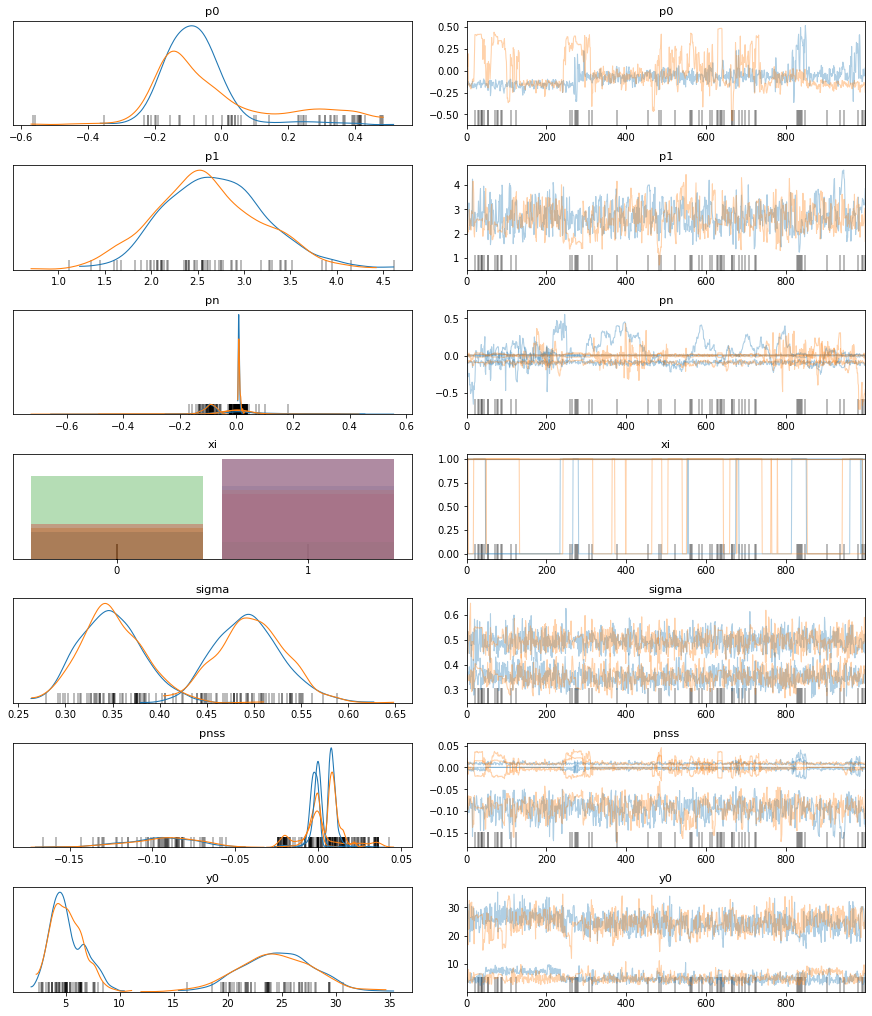

In [17]:
pm.traceplot(trace);

In [15]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p0,0.203,0.354,-0.244,0.649,0.245,0.206,2.0,2.0,3.0,27.0,1.84
p1,0.834,1.674,-1.100,3.044,1.162,0.977,2.0,2.0,3.0,30.0,1.86
pn[0],0.017,0.104,-0.215,0.189,0.011,0.008,93.0,93.0,56.0,75.0,1.07
pn[1],-0.003,0.102,-0.197,0.234,0.002,0.004,1819.0,313.0,1773.0,620.0,1.28
pn[2],-0.009,0.019,-0.035,0.014,0.013,0.011,2.0,2.0,3.0,17.0,1.83
pn[3],-0.029,0.056,-0.111,0.035,0.038,0.032,2.0,2.0,3.0,28.0,1.87
xi[0],0.164,0.371,0.000,1.000,0.192,0.148,4.0,4.0,4.0,4.0,1.52
xi[1],0.326,0.469,0.000,1.000,0.247,0.191,4.0,4.0,4.0,4.0,1.58
xi[2],1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,2000.0,2000.0,NaN
xi[3],1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,2000.0,2000.0,NaN
